In [1]:
import numpy as np
import sympy as smp
import matplotlib.pyplot as plt

from centrex_tlf import states, couplings, transitions, hamiltonian, lindblad

In [2]:
plt.rcParams.update({f"font.size": 14})

In [3]:
Ez = smp.symbols("E_z", real=True)

In [4]:
# X_states_uncoupled = states.generate_uncoupled_states_ground(Js=[0, 1, 2, 3])
X_states_uncoupled = states.generate_uncoupled_states_ground(Js=[0, 1, 2])

In [5]:
ham_uncoupled = hamiltonian.generate_uncoupled_hamiltonian_X(X_states_uncoupled)
ham_func = hamiltonian.generate_uncoupled_hamiltonian_X_function(ham_uncoupled)

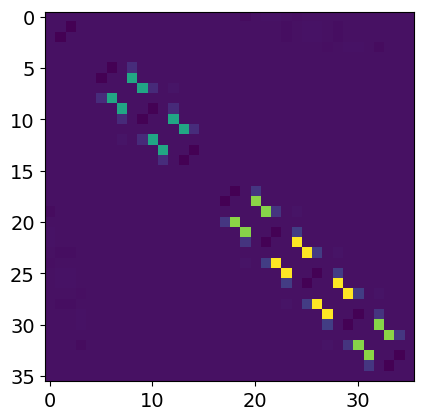

In [6]:
ham = ham_func([0, 0, 0], [0, 0, 1e-5]).real
np.fill_diagonal(ham, 0)
fig, ax = plt.subplots()

ax.imshow(ham)

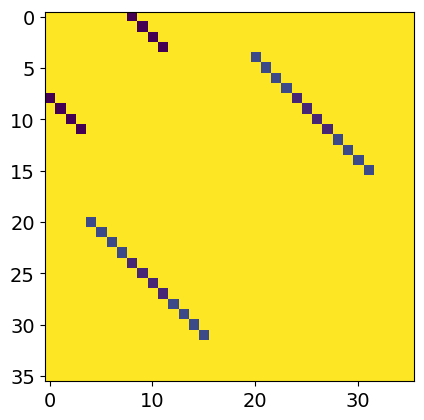

In [7]:
fig, ax = plt.subplots()

ax.imshow(ham_uncoupled.HSz.real)

In [8]:
def projectors_and_a(H0, model_idx, atol: float = 1e-12):
    """
    Return the model-space projector P0, its complement Q0,
    and the energy–denominator operator a = (E0⁰ I − H0) Q0.

    Parameters
    ----------
    H0 : np.ndarray | sympy.Matrix
        Hermitian unperturbed Hamiltonian.

    model_idx : array-like
        Indices (after diagonalisation) that define the model space.

    atol : float, optional
        Absolute tolerance for the “already diagonal” test when H0
        is given as a NumPy array.  Default is 1 × 10⁻¹².

    Returns
    -------
    P0 : same type as H0
    Q0 : same type as H0
    a  : same type as H0
    """

    # ------- helper to decide whether H0 is diagonal -----------------
    def _is_diagonal_numeric(mat, tol):
        return np.allclose(mat, np.diag(np.diag(mat)), atol=tol)

    is_sympy = isinstance(H0, smp.Matrix)
    n = H0.shape[0]

    # -------- obtain eigenvalues E and eigenvectors U ----------------
    if is_sympy:
        if getattr(H0, "is_diagonal", lambda: False)():
            # SymPy matrix already diagonal
            E = np.array([H0[i, i] for i in range(n)], dtype=float)
            U = np.eye(n, dtype=complex)
        else:
            P_sym, D_sym = H0.diagonalize()
            U = np.array(P_sym, dtype=complex)
            E = np.array(D_sym.diagonal(), dtype=float)
    else:
        H0 = np.asarray(H0, dtype=complex)
        if _is_diagonal_numeric(H0, atol):
            E = np.diag(H0).real
            U = np.eye(n, dtype=complex)
        else:
            E, U = np.linalg.eigh(H0)

    # -------- build P0 and Q0 in the eigenbasis ----------------------
    P0_eig = np.zeros((n, n), dtype=complex)
    P0_eig[np.ix_(model_idx, model_idx)] = np.eye(len(model_idx), dtype=complex)
    Q0_eig = np.eye(n, dtype=complex) - P0_eig

    # reference energy (average over the chosen degenerate manifold)
    E0 = E[model_idx].mean()

    # a in the eigenbasis: diag(E0 − Eη) inside Q, zero inside P
    a_eig = np.diag((E0 - E) * Q0_eig.diagonal())

    # -------- transform back to the original basis -------------------
    Udag = U.conj().T
    P0 = U @ P0_eig @ Udag
    Q0 = U @ Q0_eig @ Udag
    a = U @ a_eig @ Udag

    # cast back to SymPy if the input was SymPy
    if is_sympy:
        P0 = smp.Matrix(P0)
        Q0 = smp.Matrix(Q0)
        a = smp.Matrix(a)

    return P0, Q0, a


In [226]:
H0 = ham_func([0, 0, 0], [0, 0, 1e-5])
eigenvals, eigenvecs = np.linalg.eigh(H0)
H0 = np.diag(eigenvals)
HSz = eigenvecs.conj().T @ (ham_uncoupled.HSz) @ eigenvecs

# filter small values
m = np.abs(HSz) < (np.abs(HSz).max() / 1e6)
HSz[m] = 0

# make states and filter
QN = hamiltonian.matrix_to_states(eigenvecs, list(X_states_uncoupled))
QN = [qn.remove_small_components().normalize() for qn in QN]

In [227]:
QN[9]

0.61-0.00j x |J = 1, mJ = 0, I₁ = 1/2, m₁ = -1/2, I₂ = 1/2, m₂ = 1/2, P = -, Ω = 0>
-0.61+0.00j x |J = 1, mJ = 0, I₁ = 1/2, m₁ = 1/2, I₂ = 1/2, m₂ = -1/2, P = -, Ω = 0>
0.35-0.00j x |J = 1, mJ = -1, I₁ = 1/2, m₁ = 1/2, I₂ = 1/2, m₂ = 1/2, P = -, Ω = 0>
-0.35+0.00j x |J = 1, mJ = 1, I₁ = 1/2, m₁ = -1/2, I₂ = 1/2, m₂ = -1/2, P = -, Ω = 0>
-0.05+0.00j x |J = 1, mJ = 1, I₁ = 1/2, m₁ = 1/2, I₂ = 1/2, m₂ = -1/2, P = -, Ω = 0>
0.02-0.00j x |J = 1, mJ = 1, I₁ = 1/2, m₁ = -1/2, I₂ = 1/2, m₂ = 1/2, P = -, Ω = 0>

In [228]:
QN_coupled[1]

1.00+0.00j x |X, J = 0, F₁ = 1/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>

In [229]:
QN_coupled[13]

1.00+0.00j x |X, J = 1, F₁ = 3/2, F = 2, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>

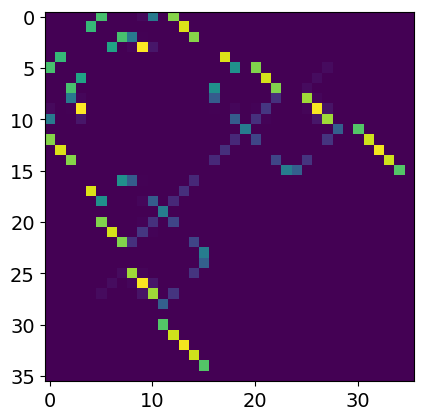

In [230]:
plt.imshow(np.abs(HSz))

In [238]:
V = HSz

Heff = smp.zeros(*H0.shape, dtype=complex)
Heff += H0

for start, stop in [(0, 4), (4, 16)]:
    P0, Q0, a = projectors_and_a(H0, list(range(start, stop)))

    a_inv = np.linalg.pinv(a, rcond=1e-14)
    # Heff += (P0 @ H0 @ P0) + (P0 @ V @ P0) * Ez
    Heff += (P0 @ V @ Q0 @ a_inv @ Q0 @ V @ P0) * Ez**2

Heff = smp.Matrix(Heff[:16, :16])

In [264]:
idx_J0 = slice(0, 4)
idx_J1 = slice(4, 16)
n0, n1 = 4, 12

N = smp.zeros(16, 16)
N[idx_J1, idx_J1] = smp.eye(n1)

C_J0J1 = smp.Matrix(
    coupling_fields[0].fields[0].field[:4, 4:16] * transition_selectors[0].Ω
)

ω = smp.Symbol("ω", real=True)
δ = smp.Symbol("δ", real=True)
t = smp.Symbol("t", real=True)
C = smp.zeros(16, 16)
C[idx_J0, idx_J1] = C_J0J1 * smp.exp(smp.I * ω * t) / 2  # your 4×12 numbers
C[idx_J1, idx_J0] = smp.conjugate(
    C_J0J1 * smp.exp(smp.I * ω * t) / 2
).T  # Hermitian adjoint

H_rot = Heff + C
# for idx in range(idx_J1.start, idx_J1.stop):
#     H_rot[idx, idx] -= ω
U = smp.eye(n0 + n1)
for idx in range(idx_J1.start, idx_J1.stop):
    U[idx, idx] = smp.exp(-smp.I * ω * t)

H_rot = U.adjoint() @ H_rot @ U + -smp.I * U.adjoint() @ smp.Derivative(U, t).doit()
H_rot = H_rot.subs({ω: H0[13, 13] - H0[1, 1] + δ})
H_rot -= smp.eye(16) * H0[1, 1]

In [267]:
H_rot

Matrix([
[-18.0249808240974*E_z**2 - 0.203910287276813,        3.0851463453797e-9*E_z**2,                 -3.81774546822388e-6*E_z**2,               -2.89835951811387e-10*E_z**2,                                                  0,                           -0.176452819885738*Ω0,                                               0,                                               0,                                               0,                         0.0061854539757208*Ω0,                          -0.102434359500784*Ω0,                                                0,                           0.204124145231932*Ω0,                                                 0,                                               0,                                                0],
[                  3.08514634781677e-9*E_z**2,         -18.0249760931216*E_z**2,                  2.00387581411366e-7*E_z**2,                   1.829567827682e-6*E_z**2,                              -0.166666666666667*Ω0,        

In [ ]:
Heff

Matrix([
[-18.0249808240974*E_z**2 - 20891.7959866281,                   3.0851463453797e-9*E_z**2,                 -3.81774546822388e-6*E_z**2,               -2.89835951811387e-10*E_z**2,                                             0,                                           0,                                          0,                                           0,                                          0,                                         0,                                         0,                                          0,                                          0,                                          0,                                          0,                                          0],
[                 3.08514634781677e-9*E_z**2, -18.0249760931216*E_z**2 - 20891.5920763408,                  2.00387581411366e-7*E_z**2,                   1.829567827682e-6*E_z**2,                                             0,                                           0,        

In [281]:
_, v0 = np.linalg.eigh(
    smp.matrix2numpy(Heff.subs(Ez, 175), dtype=np.complex128)[:4, :4]
)
_, v1 = np.linalg.eigh(
    smp.matrix2numpy(Heff.subs(Ez, 175), dtype=np.complex128)[4:16, 4:16]
)
v = np.eye(16, dtype=np.complex128)
v[:4, :4] = v0
v[4:16, 4:16] = v1

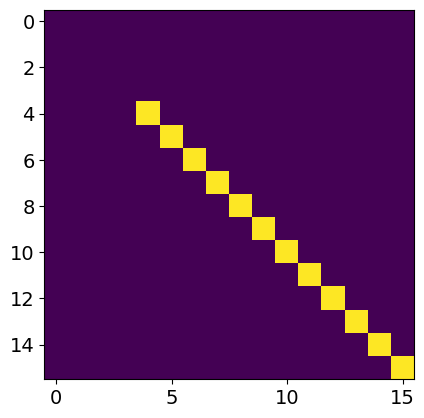

In [287]:
plt.imshow(
    (v.conj().T @ smp.matrix2numpy(Heff.subs(Ez, 175), dtype=np.complex128) @ v).real
)

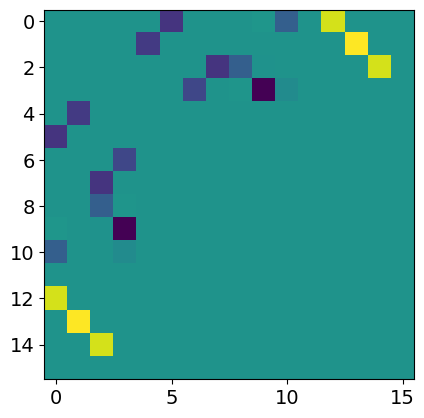

In [292]:
cpl = coupling_fields[0].fields[0].field[:16, :16]
plt.imshow(cpl.real)

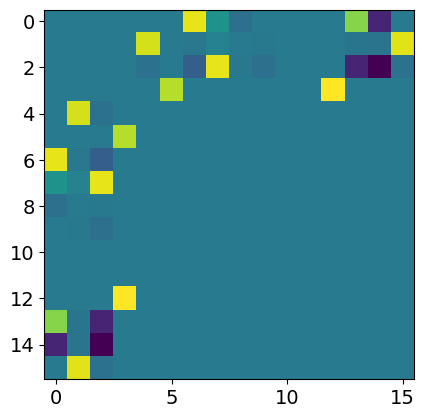

In [293]:
C = np.zeros((16, 16), dtype=np.complex128)
C[0:4, 4:16] = v0.conj().T @ cpl[0:4, 4:16] @ v1
C[4:16, 0:4] = C[0:4, 4:16].conj().T
plt.imshow(C.real)

In [265]:
QN_coupled = [qn.transform_to_coupled() for qn in QN]
QN_coupled = [qn.remove_small_components().normalize() for qn in QN_coupled]

In [266]:
from centrex_tlf.couplings.transition import TransitionSelector


trans = [
    transitions.MicrowaveTransition(0, 1),
    # transitions.MicrowaveTransition(1, 2),
]

# transition_selectors: list[TransitionSelector] = (
#     couplings.generate_transition_selectors(
#         transitions=trans,
#         polarizations=[
#             [couplings.polarization_Z, couplings.polarization_X],
#             [couplings.polarization_Z, couplings.polarization_X],
#         ],
#     )
# )

transition_selectors: list[TransitionSelector] = (
    couplings.generate_transition_selectors(
        transitions=trans,
        polarizations=[
            [couplings.polarization_Z],
            # [couplings.polarization_Z],
        ],
    )
)

QN_coupled_largest = [qn.largest for qn in QN_coupled]
coupling_fields = []
for trans in transition_selectors:
    ground_states = [
        QN_coupled[idx]
        for idx in np.unique(
            [QN_coupled_largest.index(qn.largest) for qn in trans.ground]
        )
    ]
    excited_states = [
        QN_coupled[idx]
        for idx in np.unique(
            [QN_coupled_largest.index(qn.largest) for qn in trans.excited]
        )
    ]

    cf = []
    for pol in trans.polarizations:
        cmat = couplings.generate_coupling_matrix(
            QN_coupled, ground_states, excited_states, pol
        )
        # filter small values
        cmat[np.abs(cmat) < (np.abs(cmat).max() / 1e4)] = 0
        cf.append(couplings.CouplingField(pol, cmat))

    main_coupling = np.abs(cf[0].field).max()
    idg, ide = np.where(np.abs(cf[0].field) == main_coupling)[0]
    coupling_fields.append(
        couplings.CouplingFields(
            QN_coupled[idg],
            QN_coupled[ide],
            main_coupling,
            ground_states,
            excited_states,
            cf,
        )
    )

In [50]:
H_symbolic = lindblad.generate_total_symbolic_hamiltonian(
    QN_coupled, H0, coupling_fields, transition_selectors
)

In [51]:
Ωs = [t.Ω for t in transition_selectors]
Δs = [t.δ for t in transition_selectors]
pols = []
for transition in transition_selectors:
    if not transition.polarization_symbols:
        pols.append(None)
    else:
        pols.append(transition.polarization_symbols)
ham_sym = lindblad.generate_hamiltonian.generate_symbolic_hamiltonian(
    H0, coupling_fields, Ωs, pols
)
T = lindblad.generate_unitary_transformation_matrix(ham_sym)

In [52]:
def strip_unit_floats(expr: smp.Basic) -> smp.Basic:
    """
    Recursively remove any float coefficient ±1.0 from products:
      1.0*A  → A
     -1.0*A  → -A
    Inside Add, Mul, Pow, exp(), sin(), … anything.
    """
    # 1) If it's a product, look for ±1.0
    if expr.is_Mul:
        # find all float args equal to ±1.0
        unit_floats = [
            a for a in expr.args if isinstance(a, smp.Float) and abs(a) == 1.0
        ]
        if unit_floats:
            # compute overall sign from those floats
            sign = 1
            for f in unit_floats:
                if f < 0:
                    sign *= -1
            # keep everything except those ±1.0 floats
            other = [
                a for a in expr.args if not (isinstance(a, smp.Float) and abs(a) == 1.0)
            ]
            # rebuild
            if not other:
                return smp.Integer(sign)  # e.g. expr was just -1.0 or +1.0
            core = smp.Mul(*other)
            return core if sign == 1 else -core

    # 2) Otherwise, recurse into sub-expressions
    if expr.args:
        return expr.func(*[strip_unit_floats(arg) for arg in expr.args])

    # 3) Nothing to do for symbols, Integers, Floats≠±1.0, etc.
    return expr


def clean_matrix_unit_floats(M: smp.Matrix) -> smp.Matrix:
    return M.applyfunc(strip_unit_floats)


In [53]:
def apply_ac_stark_shift(
    M: smp.Matrix, factor: float = 100, t: smp.Symbol = smp.Symbol("t", real=True)
) -> smp.Matrix:
    """
    For each upper-triangular M[n,m] = amp * exp(±I*t*det),
    shift diag m,m by +amp**2/|det|, diag n,n by -amp**2/|det|,
    and zero both off-diagonals.
    """
    M2 = M.copy()
    for n in range(M2.rows):
        for m in range(n + 1, M2.cols):
            expr = M2[n, m]
            # split off any exp(...) factor
            amp, exp_fac = expr.as_independent(smp.exp)
            if exp_fac.func is not smp.exp:
                continue

            # get the argument of the exp:
            arg = exp_fac.args[0]
            # must look like I*t*det or -I*t*det
            if not (arg.is_Mul and t in arg.args and smp.I in arg.args):
                continue

            # extract det symbol/expression:
            det = arg / (smp.I * t)

            # compute shift
            shift = amp**2 / smp.Abs(det)

            # apply to diagonals
            M2[m, m] += shift
            M2[n, n] -= shift

            # zero out Hermitian pair
            M2[n, m] = 0
            M2[m, n] = 0

    return M2


In [54]:
# energies = np.diag(H0)
energies = np.diag(ham_sym)

# transformed = smp.Matrix(
#     smp.simplify(
#         T.adjoint() @ (smp.diag(*np.diag(ham_sym)) + HSz * Ez) @ T
#         - 1j * T.adjoint() @ smp.diff(T, smp.Symbol("t", real=True))
#     )
# )
transformed = smp.Matrix(
    smp.simplify(
        T.adjoint() @ (smp.diag(*np.diag(ham_sym)) + Hperturb) @ T
        - 1j * T.adjoint() @ smp.diff(T, smp.Symbol("t", real=True))
    )
)
transformed = clean_matrix_unit_floats(transformed)
# transformed_acstark = apply_ac_stark_shift(transformed)

# for idc, (δ, coupling) in enumerate(zip(Δs, coupling_fields)):
#     # generate transition frequency symbol
#     ω = smp.Symbol(f"ω{idc}", real=True)
#     # get indices of ground and excited states
#     idg = QN_coupled.index(coupling.ground_main)
#     ide = QN_coupled.index(coupling.excited_main)

#     # transform to δ instead of ω and E
#     if idg < ide:
#         transformed = transformed.subs(ω, energies[ide] - energies[idg] + δ)
#     elif idg > ide:
#         transformed = transformed.subs(ω, energies[idg] - energies[ide] + δ)

# remove excited state energy from all diagonal entries
# for idc, (δ, coupling) in enumerate(zip(Δs, coupling_fields)):
#     idg = QN_coupled.index(coupling.ground_main)
#     expr = transformed[idg, idg]
#     for d in Δs:
#         expr = expr.subs(d, 0)

#     for idx in range(transformed.shape[0]):
#         transformed[idx, idx] -= expr

In [55]:
transformed[:10, :10]

Matrix([
[E0 - 18.0249763295215*E_z**2 + ω0,                                 0,                                 0,                                 0,                               0,                             0,                            0,                             0,                            0,                           0],
[                                0, E1 - 18.0249715985946*E_z**2 + ω0,                                 0,                                 0,                               0,                             0,                            0,                             0,                            0,                           0],
[                                0,                                 0, E2 - 18.0249763295215*E_z**2 + ω0,                                 0,                               0,                             0,                            0,                             0,                            0,                           0],
[            

In [56]:
H_symbolic[:10, :10]

Matrix([
[               δ0 - 83566.5695526167,                                    0,                                      0,                                     0,                         0, -0.354249126448805*PZ0*Ω0,                         0,                         0,                          0,   0.0124180031183819*PZ0*Ω0],
[                                   0,                δ0 - 83566.3656423294,                                      0,                                     0, -0.334602309631737*PZ0*Ω0,                         0,                         0,                         0,                          0,                           0],
[                                   0,                                    0,                  δ0 - 83566.1618396832,                                     0,                         0,                         0,                         0, -0.354249116369532*PZ0*Ω0,  -0.205993481939473*PZ0*Ω0, -0.00351459661277814*PZ0*Ω0],
[                        

In [57]:
import copy


def fill_diagonal(M: smp.Matrix, value: float) -> smp.Matrix:
    M = copy.deepcopy(M)
    for i in range(min(M.rows, M.cols)):
        M[i, i] = value
    return M

In [58]:
ham_couplings = fill_diagonal(smp.Matrix(H_symbolic), 0)
ham_couplings = clean_matrix_unit_floats(ham_couplings)

In [59]:
ham_tot = transformed + ham_couplings
ham_tot[:10, :10]

Matrix([
[   E0 - 18.0249763295215*E_z**2 + ω0,                                    0,                                      0,                                     0,                               0,     -0.354249126448805*PZ0*Ω0,                            0,                             0,                            0,   0.0124180031183819*PZ0*Ω0],
[                                   0,    E1 - 18.0249715985946*E_z**2 + ω0,                                      0,                                     0,       -0.334602309631737*PZ0*Ω0,                             0,                            0,                             0,                            0,                           0],
[                                   0,                                    0,      E2 - 18.0249763295215*E_z**2 + ω0,                                     0,                               0,                             0,                            0,     -0.354249116369532*PZ0*Ω0,    -0.205993481939473*PZ0*Ω0

In [60]:
for idc, (δ, coupling) in enumerate(zip(Δs, coupling_fields)):
    # generate transition frequency symbol
    ω = smp.Symbol(f"ω{idc}", real=True)
    # get indices of ground and excited states
    idg = QN_coupled.index(coupling.ground_main)
    ide = QN_coupled.index(coupling.excited_main)

    # transform to δ instead of ω and E
    if idg < ide:
        ham_tot = ham_tot.subs(ω, energies[ide] - energies[idg] + δ)
    elif idg > ide:
        ham_tot = ham_tot.subs(ω, energies[idg] - energies[ide] + δ)

ham_tot = ham_tot.subs([(E, val) for E, val in zip(energies, np.diag(H0))])

# remove excited state energy from all diagonal entries
for idc, (δ, coupling) in enumerate(zip(Δs, coupling_fields)):
    idg = QN_coupled.index(coupling.ground_main)
    expr = ham_tot[idg, idg]
    for d in expr.free_symbols:
        expr = expr.subs(d, 0)

    for idx in range(ham_tot.shape[0]):
        ham_tot[idx, idx] -= expr

In [61]:
ham_tot[:10, :10]

Matrix([
[-18.0249763295215*E_z**2 + δ0 - 83566.5695495605,                                                0,                                                0,                                     0,                                             0,                   -0.354249126448805*PZ0*Ω0,                                           0,                                           0,                                            0,   0.0124180031183819*PZ0*Ω0],
[                                               0, -18.0249715985946*E_z**2 + δ0 - 83566.3656463623,                                                0,                                     0,                     -0.334602309631737*PZ0*Ω0,                                           0,                                           0,                                           0,                                            0,                           0],
[                                               0,                                             

In [82]:
from sympy.printing.julia import julia_code


def sympy_matrix_to_julia_fill_hermitian(
    M: smp.Matrix, func_name: str = "fill_matrix!"
) -> tuple[str, smp.FunctionClass]:
    """
    Generate a Julia function that efficiently fills a Hermitian matrix in-place from a SymPy matrix.

    The generated Julia function optimizes performance through several strategies:
    1. Common subexpression elimination (CSE) applied only to the upper triangle
    2. Pruning of temporary variables not used in the upper triangle
    3. Inlining of temporary variables used only once
    4. Bulk zero-initialization using SIMD loops with type hoisting
    5. Computing only the upper triangle and mirroring via conjugation
    6. Emitting only non-zero assignments

    Args:
        M (smp.Matrix): A SymPy matrix (assumed Hermitian) with symbolic expressions
        func_name (str): Name for the generated Julia function (convention: use bang suffix)

    Returns:
        tuple[str, smp.FunctionClass]:
            - Julia code string for the optimized matrix-filling function
            - SymPy function object representing the call signature
    """
    rows, cols = M.rows, M.cols
    # 1) sort free symbols for deterministic argument order
    syms = sorted(M.free_symbols, key=lambda s: s.name)
    args = ", ".join(s.name for s in syms)

    # 2) run CSE on upper-triangle entries only
    upper = [M[i, j] for i in range(rows) for j in range(i, cols)]
    subs_all, reduced_upper = smp.cse(upper, symbols=smp.numbered_symbols("t"))
    # reconstruct full reduced list with Hermitian mirror
    reduced_all = [None] * (rows * cols)
    idx = 0
    for i in range(rows):
        for j in range(i, cols):
            expr = reduced_upper[idx]
            reduced_all[i * cols + j] = expr
            reduced_all[j * cols + i] = expr.conjugate() if i != j else expr
            idx += 1

    # 3) determine which temps are needed for i ≤ j
    tmp_syms = [t for t, _ in subs_all]
    used_exprs = [
        reduced_all[i * cols + j] for i in range(rows) for j in range(i, cols)
    ]
    needed = set()
    lookup = {t: expr for t, expr in subs_all}

    def mark(expr):
        for s in expr.free_symbols:
            if s in tmp_syms and s not in needed:
                needed.add(s)
                mark(lookup[s])

    for expr in used_exprs:
        mark(expr)
    pruned_subs = [(t, e) for t, e in subs_all if t in needed]

    # 4) count usage for inlining
    usage = {t: 0 for t, _ in pruned_subs}
    all_exprs = [e for _, e in pruned_subs] + used_exprs
    for expr in all_exprs:
        for t in list(usage):
            if t in expr.free_symbols:
                usage[t] += 1
    inline = {t for t, cnt in usage.items() if cnt == 1}
    keep = [(t, e) for t, e in pruned_subs if t not in inline]
    inline_map = {t: lookup[t] for t in inline}

    # 5) emit Julia code
    lines = []
    sig = f"function {func_name}(H" + (", " + args if args else "") + ")"
    lines.append(sig)
    lines.append("    @inbounds begin")
    lines.append("        zero_matrix!(H)")
    # emit kept temporaries
    for t, expr in keep:
        expr_sub = expr.subs(inline_map)
        lines.append(f"        {t} = {julia_code(expr_sub)}")
    # fill non-zero upper triangle and mirror
    for i in range(rows):
        for j in range(i, cols):
            expr = reduced_all[i * cols + j].subs(inline_map)
            if expr != 0:
                code = julia_code(expr)
                lines.append(f"        H[{i + 1},{j + 1}] = {code}")
                if i != j:
                    lines.append(
                        f"        H[{j + 1},{i + 1}] = conj(H[{i + 1},{j + 1}])"
                    )
    lines.append("    end")
    lines.append("    nothing")
    lines.append("end")
    return "\n".join(lines), smp.Function(func_name)(*syms)


In [268]:
f = sympy_matrix_to_julia_fill_hermitian(H_rot, "hamiltonian!")[1]

In [269]:
print(sympy_matrix_to_julia_fill_hermitian(H_rot, "hamiltonian!")[0])

function hamiltonian!(H, E_z, Ω0, δ)
    @inbounds begin
        zero_matrix!(H)
        t0 = E_z .^ 2
        t1 = 0.204124145231932 * Ω0
        t2 = -δ
        H[1,1] = -18.0249808240974 * t0 - 0.203910287276813
        H[1,2] = 3.0851463453797e-9 * t0
        H[2,1] = conj(H[1,2])
        H[1,3] = -3.81774546822388e-6 * t0
        H[3,1] = conj(H[1,3])
        H[1,4] = -2.89835951811387e-10 * t0
        H[4,1] = conj(H[1,4])
        H[1,6] = -0.176452819885738 * Ω0
        H[6,1] = conj(H[1,6])
        H[1,10] = 0.0061854539757208 * Ω0
        H[10,1] = conj(H[1,10])
        H[1,11] = -0.102434359500784 * Ω0
        H[11,1] = conj(H[1,11])
        H[1,13] = t1
        H[13,1] = conj(H[1,13])
        H[2,2] = -18.0249760931216 * t0
        H[2,3] = 2.00387581411366e-7 * t0
        H[3,2] = conj(H[2,3])
        H[2,4] = 1.829567827682e-6 * t0
        H[4,2] = conj(H[2,4])
        H[2,5] = -0.166666666666667 * Ω0
        H[5,2] = conj(H[2,5])
        H[2,14] = 0.235702260395516 * Ω0
 

In [271]:
with open("hamiltonian.jl", "w") as file:
    _ham = copy.deepcopy(H_rot)
    for trans in transition_selectors:
        _ham = _ham.subs(trans.polarization_symbols[0], 1.0)
    _ham = smp.simplify(_ham)
    file.write(sympy_matrix_to_julia_fill_hermitian(_ham, "hamiltonian!")[0])

In [66]:
rho = smp.MatrixSymbol("rho", *H0.shape)
comm = -smp.I * (ham_tot * rho - rho * ham_tot)

In [67]:
smp.simplify(comm._entry(0, 0, expand=False))

I*PZ0*(0.354249126448805*Ω0*rho[5, 0] - 0.0124180031183819*Ω0*rho[9, 0] + 0.205648639647661*Ω0*rho[10, 0] - 0.40980246267725*Ω0*rho[12, 0] - 0.354249126448805*conjugate(Ω0)*rho[0, 5] + 0.0124180031183819*conjugate(Ω0)*rho[0, 9] - 0.205648639647661*conjugate(Ω0)*rho[0, 10] + 0.40980246267725*conjugate(Ω0)*rho[0, 12])

In [63]:
def hermitian_comm(H: smp.Matrix, R: smp.MatrixSymbol) -> smp.Matrix:
    """
    Compute the commutator [H, R] = H*R - R*H for a Hermitian dense matrix H
    and a Hermitian matrix symbol R, using optimized Python loops:

    - Pre-extract H and R entries into Python lists for fast indexing.
    - Sum only the upper triangle (i ≤ j) and mirror via the anti-Hermitian property.
    - Minimize Python overhead by caching rows and avoiding repeated attribute lookups.

    Args:
        H (sympy.Matrix): n×n Hermitian dense matrix of symbols or expressions.
        R (sympy.MatrixSymbol): n×n Hermitian matrix symbol.

    Returns:
        sympy.Matrix: n×n Matrix where
            for i ≤ j: entry = -I*(sum_k H[i,k]*R[k,j] - sum_k R[i,k]*H[k,j])
            for i > j: entry = -conjugate(entry[j,i]).
    """
    I = smp.I
    n = H.rows

    # Convert H to Python list-of-lists for fast indexing
    Hdata = H.tolist()
    # Pre-extract R elements into Python lists to avoid MatMul._entry overhead
    Rdata = [[R[i, j] for j in range(n)] for i in range(n)]

    # Preallocate output container
    out = [[None] * n for _ in range(n)]

    # Compute only upper triangle and mirror
    for i in range(n):
        Hi = Hdata[i]
        Ri = Rdata[i]
        for j in range(i, n):
            # initialize sums for H*R and R*H
            a = Hi[0] * Rdata[0][j]
            b = Ri[0] * Hdata[0][j]
            # accumulate remaining terms
            for k in range(1, n):
                a += Hi[k] * Rdata[k][j]
                b += Ri[k] * Hdata[k][j]
            # build commutator entry
            s = -I * (a - b)
            out[i][j] = s
            if i != j:
                # mirror via anti-Hermitian property
                out[j][i] = s.conjugate()

    # Construct the final sympy Matrix in one go
    return smp.Matrix(out)


In [ ]:
from sympy.printing.julia import julia_code


def sympy_matrix_to_julia_fill_hermitian_density(
    M: smp.Matrix, func_name: str = "fill_matrix!", rho_arg: str = "rho"
) -> str:
    """
    Generate a Julia function that efficiently fills an existing Hermitian matrix in-place
    based on a SymPy Matrix M of expressions that may include a MatrixSymbol 'rho'.

    The Julia function signature will be:
        function {func_name}(A, {rho_arg})
    where 'A' is the target matrix and '{rho_arg}' is the n×n rho array.

    This generator applies:
      1. Global common subexpression elimination (CSE) over all non-rho entries.
      2. Pruning of temps not needed for upper triangle.
      3. Inlining of temps used only once.
      4. Bulk zero-init via @simd loop with hoisted zero.
      5. Computation of upper triangle and mirroring via conj(A).
      6. Emission of only non-zero assignments.
      7. Hoisting eltype(A) and zero(T) out of loops.

    Args:
        M (smp.Matrix): Hermitian sympy Matrix, containing expressions in H_ij and rho[i,j].
        func_name (str): Julia function name (with bang).
        rho_arg (str): Name of the Julia rho array argument.

    Returns:
        str: Julia source for the in-place fill function.
    """
    n = M.rows
    # 1) Identify free symbols excluding matrix accesses for rho
    # We treat any MatrixSymbol 'rho' as the rho_arg array
    syms = [s for s in M.free_symbols if not (isinstance(s, smp.MatrixExpr))]
    args = ", ".join(s.name for s in syms)

    # 2) CSE over only upper-triangle entries of M
    upper = [M[i, j] for i in range(n) for j in range(i, n)]
    subs_all, reduced_upper = smp.cse(upper, symbols=smp.numbered_symbols("t"))
    # build the flattened reduced_all with Hermitian mirror
    reduced_all = [None] * (n * n)
    idx = 0
    for i in range(n):
        for j in range(i, n):
            expr = reduced_upper[idx]
            reduced_all[i * n + j] = expr
            # mirror lower triangle via conjugate
            reduced_all[j * n + i] = expr.conjugate() if i != j else expr
            idx += 1

    # 3) Determine temps used in upper triangle
    tmp_syms = [t for t, _ in subs_all]
    used = []
    for i in range(n):
        for j in range(i, n):
            used.append(reduced_all[i * n + j])
    needed = set()
    lookup = {t: expr for t, expr in subs_all}

    def mark(expr):
        for s in expr.free_symbols:
            if s in tmp_syms and s not in needed:
                needed.add(s)
                mark(lookup[s])

    for e in used:
        mark(e)
    pruned = [(t, e) for t, e in subs_all if t in needed]

    # 4) Inline single-use temps
    usage = {t: 0 for t, _ in pruned}
    for expr in [e for _, e in pruned] + used:
        for t in list(usage):
            if t in expr.free_symbols:
                usage[t] += 1
    inline = {t for t, c in usage.items() if c == 1}
    keep = [(t, e) for t, e in pruned if t not in inline]
    inline_map = {t: lookup[t] for t in inline}

    # 5) Emit Julia code
    lines = []
    sig = f"function {func_name}(A, {rho_arg}" + (", " + args if args else "") + ")"
    lines.append(sig)
    lines.append("    @inbounds begin")
    lines.append("        zero_matrix!(A)")
    # emit temps
    for t, expr in keep:
        expr2 = expr.subs(inline_map)
        lines.append(f"        {t} = {julia_code(expr2)}")
    # fill upper triangle and mirror
    for i in range(n):
        for j in range(i, n):
            e = reduced_all[i * n + j].subs(inline_map)
            if e != 0:
                code = julia_code(e)
                # replace rho MatrixElement with rho_arg indexing
                code = code.replace("rho[", f"{rho_arg}[")
                lines.append(f"        A[{i + 1},{j + 1}] = {code}")
                if i != j:
                    lines.append(
                        f"        A[{j + 1},{i + 1}] = conj(A[{i + 1},{j + 1}])"
                    )
    lines.append("    end")
    lines.append("    nothing")
    lines.append("end")
    return "\n".join(lines)


In [64]:
comm = hermitian_comm(ham_tot, rho)

In [ ]:
print(sympy_matrix_to_julia_fill_hermitian_density(comm, "commutator!"))

function commutator!(A, rho, PZ1, Ω0, δ1, PX1, E_z, PX0, PZ0, δ0, Ω1)
    @inbounds begin
        T = eltype(A)
        z = zero(T)
        @simd for i in 1:64, j in 1:64
            A[i,j] = z
        end
        t0 = 0.167316081808844 * PX0
        t1 = 0.00125693286186426 * PZ0 + t0
        t2 = t1 .* Ω0
        t3 = t2 .* rho[14,1]
        t4 = 0.145394393283425 * PX0
        t5 = -0.0132110948195287 * PZ0 + t4
        t6 = t5 .* Ω0
        t7 = t6 .* rho[10,1]
        t8 = 0.00934165512623288 * PX0
        t9 = 0.205618714216985 * PZ0 + t8
        t10 = conj(Ω0)
        t11 = t10 .* rho[1,11]
        t12 = t11 .* t9
        t13 = t9 .* Ω0
        t14 = t13 .* rho[11,1]
        t15 = t10 .* rho[1,14]
        t16 = t1 .* t15
        t17 = t10 .* rho[1,10]
        t18 = t17 .* t5
        t19 = PX0 .* t10
        t20 = 0.250515483586973 * t19
        t21 = t20 .* rho[1,7]
        t22 = 0.354282399519177 * PZ0
        t23 = t10 .* t22
        t24 = t23 .* rho[1,6]
        t25 = 0.40984

In [214]:
import tqdm
from state_prep.electric_fields import Ez_from_csv

electric_field = Ez_from_csv()

# _ham = copy.deepcopy(ham_tot)
_ham = smp.Matrix(H0 + HSz * Ez)
for fs in _ham.free_symbols:
    if fs == Ez:
        continue
    _ham = _ham.subs(fs, 0)

display(_ham[:5, :5])

x = np.linspace(-0.2, 0.15, 251)
eigenvalues = []
for Ez_val in tqdm.tqdm(electric_field(x)):
    _h = _ham.subs(Ez, Ez_val)
    vals, vecs = np.linalg.eigh(smp.matrix2numpy(_h, dtype=np.complex128))
    eigenvalues.append(vals)
eigenvalues = np.array(eigenvalues)

Matrix([
[   -20891.7959866281,                     0,                 0,                0,  15.7319721359534*E_z],
[                   0,     -20891.5920763408,                 0,                0, -709508.499306837*E_z],
[                   0,                     0, -20891.3882736947,                0,                     0],
[                   0,                     0,                 0, 62674.7735659886,                     0],
[15.7319721359534*E_z, -709508.499306837*E_z,                 0,                0,      83783247293.1784]])

100%|██████████| 251/251 [00:32<00:00,  7.65it/s]


In [242]:
_ham = copy.deepcopy(H_rot)
for fs in _ham.free_symbols:
    if fs == Ez:
        continue
    _ham = _ham.subs(fs, 0)

display(_ham[:5, :5])

x = np.linspace(-0.2, 0.15, 251)
eigenvalues_other = []
for Ez_val in tqdm.tqdm(electric_field(x)):
    _h = _ham.subs(Ez, Ez_val)
    vals, vecs = np.linalg.eigh(smp.matrix2numpy(_h, dtype=np.complex128))
    eigenvalues_other.append(vals)
eigenvalues_other = np.array(eigenvalues_other)


Matrix([
[-18.0249808240974*E_z**2 - 20891.7959866281,                   3.0851463453797e-9*E_z**2,                 -3.81774546822388e-6*E_z**2,               -2.89835951811387e-10*E_z**2,                           0],
[                 3.08514634781677e-9*E_z**2, -18.0249760931216*E_z**2 - 20891.5920763408,                  2.00387581411366e-7*E_z**2,                   1.829567827682e-6*E_z**2,                           0],
[                -3.81774546822367e-6*E_z**2,                  2.00387581408253e-7*E_z**2, -18.0249808239978*E_z**2 - 20891.3882736947,                -5.56723681420161e-7*E_z**2,                           0],
[               -2.89835930556352e-10*E_z**2,                  1.82956782851098e-6*E_z**2,                 -5.56723681424732e-7*E_z**2, 62674.7735659886 - 18.0249612686593*E_z**2,                           0],
[                                          0,                                           0,                                           0,                

  0%|          | 0/251 [00:00<?, ?it/s]

100%|██████████| 251/251 [00:17<00:00, 14.08it/s]


Text(0, 0.5, 'energy (MHz)')

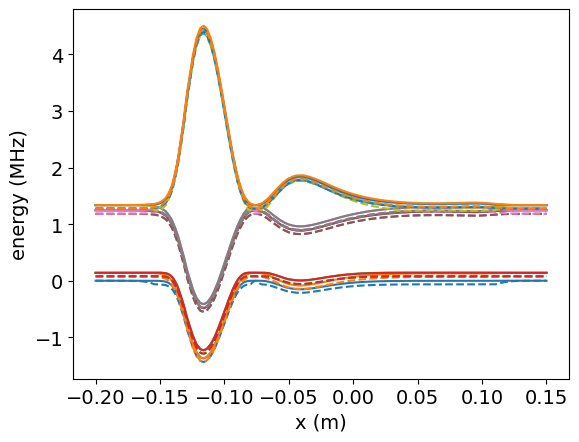

In [243]:
fig, ax = plt.subplots()
for idv in range(4, 16):
    (line,) = ax.plot(x, (eigenvalues[:, idv] - eigenvalues[0, 4]) / 1e6)
    ax.plot(
        x,
        (eigenvalues_other[:, idv] - eigenvalues_other[0, 4]) / 1e6,
        color=line.get_color(),
        ls="--",
    )
# ax1 = ax.twinx()
# ax1.plot(x, electric_field(x), color="k", linestyle="--")
# ax1.set_ylabel("Electric field (V/m)")
ax.set_xlabel("x (m)")
ax.set_ylabel("energy (MHz)")

In [174]:
Hi = ham_func(E=[0, 0, 1e-3], B=[0, 0, 1e-3])
E, V = np.linalg.eigh(Hi)

# get the true superposition-states of the system
QN_states = copy.deepcopy(QN)

# original eigenvectors used in tracking states as energies change order
V_track = V.copy()


Ezs = electric_field(x)
# empty array for storing energies
energy = np.empty([Ezs.size, len(QN)], dtype=np.complex128)

# iterate over the electric field values
for idx, Ei in enumerate(Ezs):
    Hi = ham_func(E=[0, 0, Ei], B=[0, 0, 1e-3])
    E, V = np.linalg.eigh(Hi)

    # sort indices to keep the state order the same
    indices = np.argmax(np.abs(V_track.conj().T @ V), axis=1)
    energy[idx, :] = E[indices]
    V_track[:, :] = V[:, indices]
energy = energy.real

In [181]:
for idqn, qn in enumerate(QN_coupled):
    if qn.largest.mF == 0 and qn.largest.J < 2:
        print(idqn, qn.largest)

1 |X, J = 0, F₁ = 1/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>
3 |X, J = 0, F₁ = 1/2, F = 0, mF = 0, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>
4 |X, J = 1, F₁ = 1/2, F = 0, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
6 |X, J = 1, F₁ = 1/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
9 |X, J = 1, F₁ = 3/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
13 |X, J = 1, F₁ = 3/2, F = 2, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>


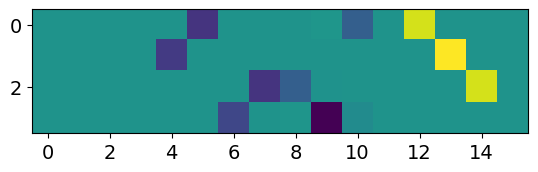

In [191]:
plt.imshow(coupling_fields[0].fields[0].field[:4, :16].real)

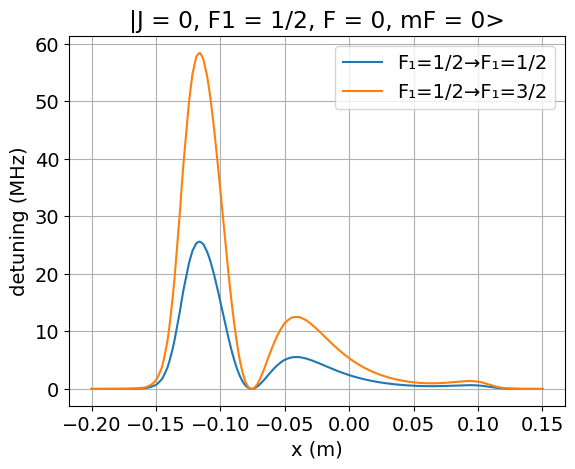

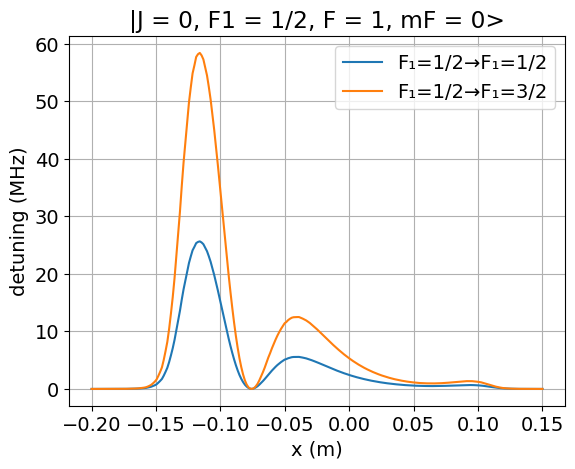

In [251]:
fig, ax = plt.subplots()

ax.plot(
    x,
    ((energy[:, 6] - energy[:, 3]) - energy[0, 6]) / (2 * np.pi * 1e6),
    label="F₁=1/2→F₁=1/2",
)
ax.plot(
    x,
    ((energy[:, 9] - energy[:, 3]) - energy[0, 9]) / (2 * np.pi * 1e6),
    label="F₁=1/2→F₁=3/2",
)
ax.set_xlabel("x (m)")
ax.set_ylabel("detuning (MHz)")
ax.set_title(QN_coupled[3].largest.state_string_custom(["J", "F1", "F", "mF"]))
ax.legend()
ax.grid()

fig, ax = plt.subplots()

ax.plot(
    x,
    ((energy[:, 4] - energy[:, 1]) - energy[0, 4]) / (2 * np.pi * 1e6),
    label="F₁=1/2→F₁=1/2",
)
ax.plot(
    x,
    ((energy[:, 13] - energy[:, 1]) - energy[0, 13]) / (2 * np.pi * 1e6),
    label="F₁=1/2→F₁=3/2",
)
ax.set_xlabel("x (m)")
ax.set_ylabel("detuning (MHz)")
ax.set_title(QN_coupled[1].largest.state_string_custom(["J", "F1", "F", "mF"]))
ax.legend()
ax.grid()


In [138]:
Δ = 3000
Ω0, Ω1 = smp.symbols("Ω_0 Ω_1", complex=True)
ω0, ω1 = smp.symbols("ω_0 ω_1", real=True)
t = smp.symbols("t", real=True)
drive0 = Ω0 * (smp.exp(-smp.I * ω0 * t)) / 2
drive1 = Ω1 * (smp.exp(-smp.I * ω1 * t)) / 2
coupling0 = smp.Matrix([[0, drive0, 0], [smp.conjugate(drive0), 0, 0], [0, 0, 0]])
coupling1 = smp.Matrix([[0, 0, 0], [0, 0, drive1], [0, smp.conjugate(drive1), 0]])
ham_test_static = smp.Matrix([[0, 0, 0], [0, Δ, 0], [0, 0, 2 * Δ]])
ham_test_Hstark = smp.Matrix([[0, 1 * Ez, 0], [1 * Ez, 0, 2 * Ez], [0, 2 * Ez, 0]])

ham_test = ham_test_static + ham_test_Hstark + coupling0 + coupling1
ham_test

Matrix([
[                                  0,             E_z + Ω_0*exp(-I*t*ω_0)/2,                           0],
[E_z + exp(I*t*ω_0)*conjugate(Ω_0)/2,                                  3000, 2*E_z + Ω_1*exp(-I*t*ω_1)/2],
[                                  0, 2*E_z + exp(I*t*ω_1)*conjugate(Ω_1)/2,                        6000]])

In [140]:
ham_test_perturb = ham_test_static + smp.Matrix(
    [
        [-(Ez**2) / Δ, 0, 0],
        [0, Ez**2 / Δ - 4 * Ez**2 / Δ, 0],
        [0, 0, +4 * Ez**2 / Δ],
    ]
)
ham_test_perturb

Matrix([
[-E_z**2/3000,                  0,                 0],
[           0, 3000 - E_z**2/1000,                 0],
[           0,                  0, E_z**2/750 + 6000]])

In [139]:
def auto_rwa(H_lab, t):
    """
    Rotating-wave approximation + AC–Stark shifts for a SymPy Hamiltonian.

    Parameters
    ----------
    H_lab : smp.Matrix
        Lab-frame Hamiltonian.  Off-diagonal drives must appear as factors
        exp(±I*ω*t).  The routine detects every unique ω_ij symbol.
    t : sympy.Symbol
        Time variable used inside H_lab.

    Returns
    -------
    R       : smp.Matrix            diag(exp(-I*chi_k t))
    H_rwa   : smp.Matrix            Hamiltonian after RWA + Stark shifts
    det_map : dict {(i,j): δ_ij}    symbolic detunings  (i<j)
    chis    : list                  solved chi_k values
    """
    N = H_lab.rows
    E = [smp.simplify(H_lab[k, k]) for k in range(N)]  # bare energies

    # ---- 1.  find ω_ij symbols -------------------------------------------
    omega_sym = {}  # (i,j) → ω symbol
    for i in range(N):
        for j in range(i + 1, N):
            for e in H_lab[i, j].atoms(smp.exp):
                arg = smp.expand(e.args[0])  # I*ω*t
                ω = smp.expand(arg / (smp.I * t))
                if ω.free_symbols:  # is a symbol
                    omega_sym[(i, j)] = ω
                    break

    # ---- 2.  introduce detunings   ω_ij = ΔE + δ_ij -----------------------
    det_map, subs = {}, {}
    for (i, j), ω in omega_sym.items():
        δ = smp.symbols(f"delta_{i}{j}", real=True)
        det_map[(i, j)] = δ
        ΔE = E[j] - E[i]
        subs[ω] = ΔE + δ
        subs[-ω] = -(ΔE + δ)

    H_sub = H_lab.subs(subs)

    # ---- 3.  solve for χ_k :   χ_j - χ_i = ω_ij ---------------------------
    chisyms = smp.symbols(f"chi0:{N}", real=True)
    eqs = [chisym for chisym in [chisyms[0]]]  # χ0 = 0
    for (i, j), ω in omega_sym.items():
        eqs.append(chisyms[j] - chisyms[i] - subs[ω])

    chis = list(smp.linsolve(eqs, *chisyms).args[0])

    # ---- 4.  build R and transform  --------------------------------------
    R = smp.diag(*[smp.exp(-smp.I * chi * t) for chi in chis])
    H_rot = R.H * H_sub * R - smp.I * R.H * smp.diff(R, t)

    # ---- 5.  split slow vs fast terms, add AC-Stark shift -----------------
    H_rwa = smp.zeros(N)
    # start with diagonal part (already slow) …
    for k in range(N):
        H_rwa[k, k] = smp.expand(H_rot[k, k])

    for i in range(N):
        for j in range(i + 1, N):
            slow_terms = []  # to keep explicitly
            for term in smp.expand(H_rot[i, j]).as_ordered_terms():
                exps = list(term.atoms(smp.exp))
                if not exps:  # --- truly slow term
                    slow_terms.append(term)
                else:  # --- fast term → Stark
                    # assume single exp factor
                    arg = smp.expand(exps[0].args[0])  # I*Ω*t
                    Ω = smp.expand(arg / (smp.I * t))
                    g = smp.simplify(term / exps[0])  # prefactor
                    shift = smp.simplify(g * smp.conjugate(g) / Ω)
                    H_rwa[i, i] += shift
                    H_rwa[j, j] -= shift
            if slow_terms:
                H_rwa[i, j] = smp.Add(*slow_terms)
                H_rwa[j, i] = smp.conjugate(H_rwa[i, j])

    # H_rwa = H_rot.applyfunc(slow_part)

    return R, smp.simplify(H_rwa), det_map, chis


In [141]:
res = auto_rwa(ham_test, t)

In [142]:
res[1]

Matrix([
[    -E_z**2/3000,                                      Ω_0/2,                                       0],
[conjugate(Ω_0)/2, E_z**2/3000 - 4*E_z**2/delta_12 - delta_01,                                   Ω_1/2],
[               0,                           conjugate(Ω_1)/2, 4*E_z**2/delta_12 - delta_01 - delta_12]])

In [141]:
x = np.linspace(-0.2, 0.15, 251)
eigenvalues = []
for Ez_val in tqdm.tqdm(electric_field(x)):
    _h = ham_test.subs(Ez, Ez_val)
    for fs in _h.free_symbols:
        _h = _h.subs(fs, 0)
    vals, vecs = np.linalg.eigh(smp.matrix2numpy(_h, dtype=np.complex128))
    eigenvalues.append(vals)
eigenvalues = np.array(eigenvalues)


  0%|          | 0/251 [00:00<?, ?it/s]


NameError: name 'ham_test' is not defined

In [144]:
x = np.linspace(-0.2, 0.15, 251)
eigenvalues_other = []
for Ez_val in tqdm.tqdm(electric_field(x)):
    _h = ham_test_perturb.subs(Ez, Ez_val)
    vals, vecs = np.linalg.eigh(smp.matrix2numpy(_h, dtype=np.complex128))
    eigenvalues_other.append(vals)
eigenvalues_other = np.array(eigenvalues_other)


  0%|          | 0/251 [00:00<?, ?it/s]

100%|██████████| 251/251 [00:00<00:00, 580.19it/s]


Text(0, 0.5, 'energy (MHz)')

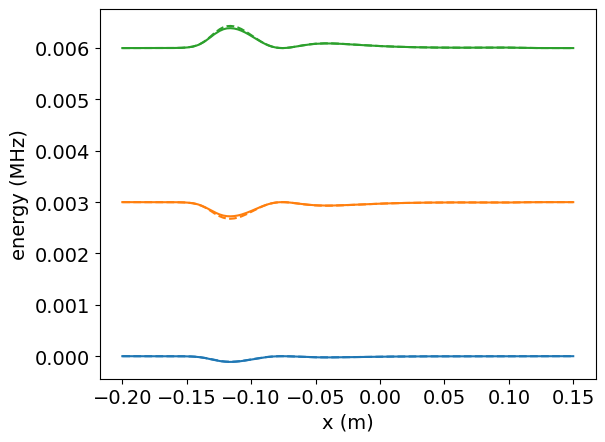

In [145]:
fig, ax = plt.subplots()
for idv in range(0, 3):
    (line,) = ax.plot(x, (eigenvalues[:, idv] - eigenvalues[0, 0]) / 1e6)
    ax.plot(
        x,
        (eigenvalues_other[:, idv] - eigenvalues_other[0, 0]) / 1e6,
        color=line.get_color(),
        ls="--",
    )
# ax1 = ax.twinx()
# ax1.plot(x, electric_field(x), color="k", linestyle="--")
# ax1.set_ylabel("Electric field (V/m)")
ax.set_xlabel("x (m)")
ax.set_ylabel("energy (MHz)")


In [99]:
from centrex_tlf import utils

utils.rabi.rabi_to_power_gaussian_beam_microwave(
    0.5 * hamiltonian.Γ, 0.5, 1.078e-2, 1.078e-2
)

0.005212541777188738

In [107]:
v, _ = np.linalg.eigh(H0 + HSz * 172)
v0, _ = np.linalg.eigh(H0)

In [110]:
(v0[4] - v0[0]) / (2 * np.pi * 1e6)

np.float64(13334.521280032606)

In [111]:
(v[4] - v[0]) / (2 * np.pi * 1e6)

np.float64(13334.600825131865)